## <center>Sales Opportunity Scoring Using scikit-learn</center>

## <center>Submitted By</center>

## <center>Ben Karabinus</center>

## <center>University of Denver</center>

## <center> Ritchie School of Engineering and Computer Science</center>

## <center>COMP 4448, Data Science Tools 2</center>

## <center>Summer Quarter 2022</center>

## _Opportunity Scoring Motivation_

A sales opportunity can be defined as a sales account that has been qualified as showing legitimate interest in purchasing a product or service from another business entity. Businesses with sales departments commonly track opportunities through software using a customer relationship management system (CRM). CRM applications store attributes related to opportunities in an organization's sales pipeline. Attributes regarding a given opportunity may include what products or services are potentially being purchased, details of any existing relationship with the individual or company listed on an opportunity record, or which sales representative owns a given opportunity. Sales teams use this information to determine which pursuits have the greatest likelihood of success and therefore should be pursued more aggressively. This project tests the effectiveness of predicting win or loss for sales opportunities currently in an organization's pipeline using classification algorithms. The following algorithms will be applied to the data using the __[scikit-learn module](https://scikit-learn.org/stable/)__ available for import in Python 3.x:

- Support Vector Classification
- Decision Tree Classification
- Random Forest Classification
- Logistic Regression

## *Project Setup and Data Import*

In [1]:
"""import the necessary libraries"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msngo
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [2]:
"""load the opportunities data"""

opportunities = pd.read_csv('opportunities.csv')
opportunities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2593 entries, 0 to 2592
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   opportunity_id                  2593 non-null   object 
 1   Entity_ID                       2593 non-null   int64  
 2   Est_Revenue                     2593 non-null   float64
 3   Annual_Revenue                  2593 non-null   int64  
 4   days_active                     2593 non-null   float64
 5   PFY_RSM_Services_Spend          2593 non-null   float64
 6   CFY_RSM_Services_Spend          2593 non-null   float64
 7   No_of_Employees                 2593 non-null   int64  
 8   Probability                     2593 non-null   object 
 9   Lead_Source                     2593 non-null   object 
 10  Private_Equity                  2593 non-null   object 
 11  Open_Revenue                    2593 non-null   float64
 12  Type                            25

## *Sales Opportunity Data*

The dataset used for this project was exported from Dynamics CRM, a cloud-hosted customer relationship management system built on Microsoft Dataverse. Records describe opportunities created by sales professionals that work for a consulting firm specializing in the implementation and management of business applications. Sales pursuits range from full scale enterprise resource planning (ERP) software implementations costing millions of dollars to short-term agreements for providing consulting services.

## *Data Preprocessing*

 *Objectives*

 - Clean column names and reset dataframe index to unique value of opportunity_id and entity_id.
 - Drop records that were active for less than 10 days.
 - Create a new feature specifying ratio of record completeness.
 - Drop feature revenue_size
 - Drop feature type
 - Drop feature lead_source
 - Drop feature industry_sector
 - Check for missing data, determine the missingness mechanism.
 - Handle missing data appropriately.
 - Create a new feature specifying RSM segment (market segment).
 - Convert categorical features to category data type.
 - Split data into training and test sets

### Clean column names and reset dataframe index to unique value of opportunity_id and entity_id

In [3]:
"""clean column names, opportunities dataframe"""

# get column names
opportunities.columns = opportunities.columns.str.lower()

In [4]:
"""set dataframe index to unique combination of opportunity_id and entity_id"""

opportunities.set_index(['opportunity_id', 'entity_id'], inplace=True)

Drop records that were active for less than 10 days

In [5]:
opportunities = opportunities[opportunities['days_active'] >= 10]

Create a new feature specifying record completeness

In [6]:
"""count missing values in each column, represent new attribute as ratio of complete attributes per record"""

# transform values "_missing_" to None
opportunities = opportunities.applymap(lambda x : None if x == "_missing_" else x)
# get number of features in the data
denominator = opportunities.shape[1]
# count number of missing values per row and assign to feature record_completeness
opportunities.insert(loc=opportunities.shape[1]-1, column='record_completeness', value=opportunities.isnull().sum(axis=1))
# express record completeness as percentage of complete attributes per record
opportunities['record_completeness'] = opportunities['record_completeness'].apply(lambda x: 1-(x/denominator))

Create a new feature specifying RSM segment (market segment)

In [7]:
"""create new feature revenue_size as a categroical representation of estimated revenue (market segment) for a given opportunity"""

opportunities.insert(loc=opportunities.shape[1]-1, column='segment', value=pd.cut(x=opportunities['annual_revenue'],
                    bins=[-1, 5000000, 30000000, 100000000, 1000000000, 1000000000000],
                    labels=['below_middle', 'lower_middle','middle_market', 'upper_middle', 'up_market']))

Categorical features that can take on a broad range of values should be dropped. These features will lead to issues with dimensionality when applying one hot encoding to the data prior to model building.

Drop feature revenue_size

In [8]:
"""drop the revenue_size feature"""

opportunities.drop(columns=['revenue_size'], inplace=True)

Drop feature type

In [9]:
"""drop the type feature"""

opportunities.drop(columns=['type'], inplace=True)

Drop feature industry_sector

In [10]:
opportunities.drop(columns=['industry_sector'], inplace=True)

Drop the feature lead_source

In [11]:
opportunities.drop(columns=['lead_source'], inplace=True)

Check for missing data, determine the missingness mechanism

In [12]:
"print a ratio of missing values by feature"

opportunities.isnull().mean()

est_revenue                       0.000000
annual_revenue                    0.000000
days_active                       0.000000
pfy_rsm_services_spend            0.000000
cfy_rsm_services_spend            0.000000
no_of_employees                   0.000000
probability                       0.077253
private_equity                    0.114270
open_revenue                      0.000000
microsoft_enterprise_agreement    0.407725
record_completeness               0.000000
segment                           0.000000
won                               0.000000
dtype: float64

<AxesSubplot:>

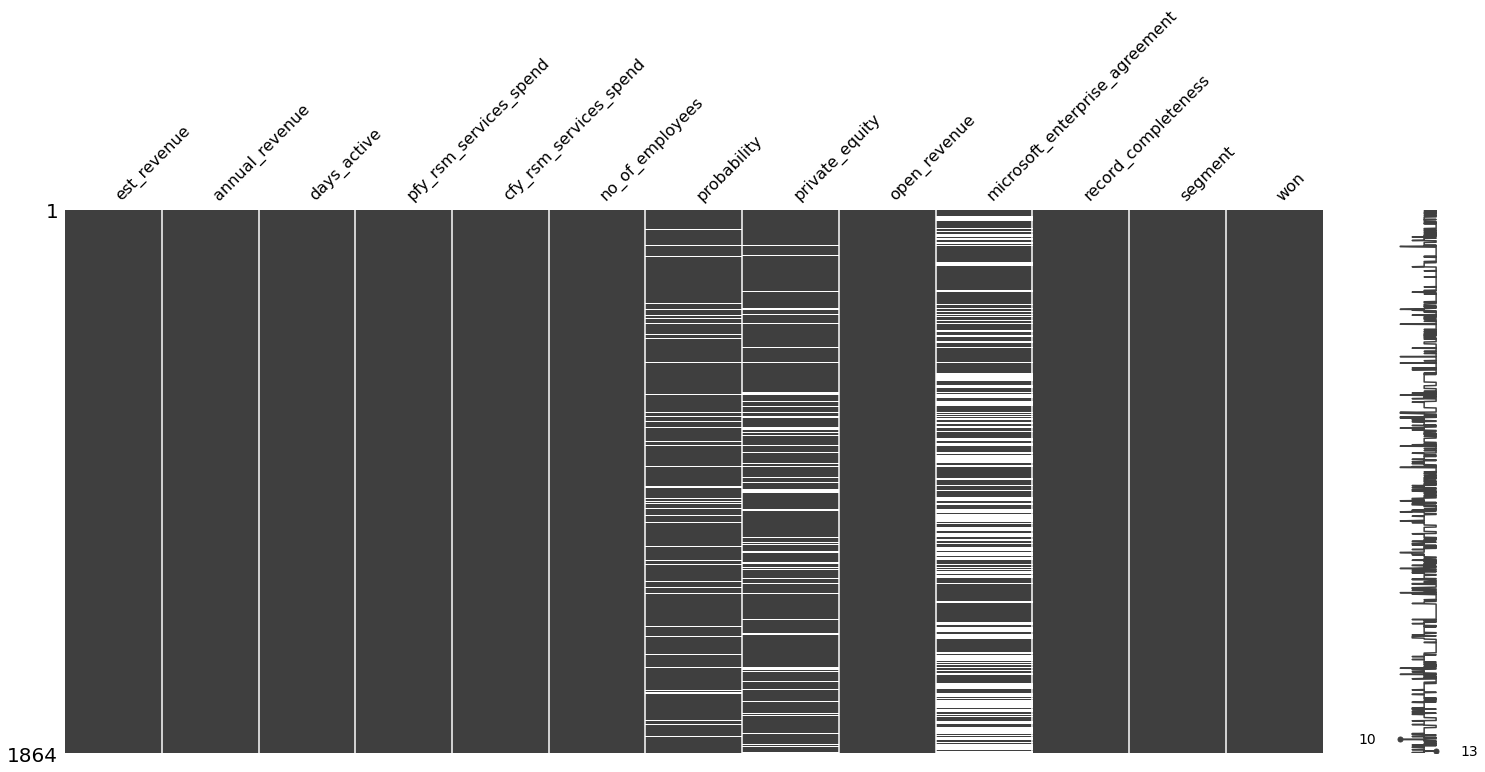

In [13]:
"""
print missing matrix for data using missingo module
missing matrix will provide high-level view of missingness mechanism (MCAR, MAR, NMAR)
"""

msngo.matrix(opportunities)

Data appears to be either missing completely at random (MCAR) or missing at random (MAR). Features missing 30% or more observations will be dropped. Mode imputation will be applied to discrete features missing between 5% and 29% of observations.

In [14]:
"""handle missing data"""

# drop microsoft_enterprise_agreement_feature
opportunities.drop(columns=['microsoft_enterprise_agreement'], inplace=True)
# apply mode imputation to the probability feature
opportunities['probability'].fillna(opportunities['probability'].mode()[0], inplace=True)
# apply mode imputation to the private_equity feature
opportunities['private_equity'].fillna(opportunities['private_equity'].mode()[0], inplace=True)
# print sum of null values to verify replacement
opportunities.isnull().sum()

est_revenue               0
annual_revenue            0
days_active               0
pfy_rsm_services_spend    0
cfy_rsm_services_spend    0
no_of_employees           0
probability               0
private_equity            0
open_revenue              0
record_completeness       0
segment                   0
won                       0
dtype: int64

### Convert categorical features to category data type

In [15]:
"""convert categorical features to proper data type"""

# get index of categorical features
categorical_idx = opportunities.select_dtypes(include=['bool', 'object', 'category'])
# convert to categorical dtype
for feature in categorical_idx:
    opportunities[feature] = opportunities[feature].astype('category')
# verify conversion
opportunities.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1864 entries, ('8549a452-2d9b-e711-8118-005056ad09ed', 7787042) to ('d3ab2c66-ec15-e711-8114-005056ad6943', 7785141)
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   est_revenue             1864 non-null   float64 
 1   annual_revenue          1864 non-null   int64   
 2   days_active             1864 non-null   float64 
 3   pfy_rsm_services_spend  1864 non-null   float64 
 4   cfy_rsm_services_spend  1864 non-null   float64 
 5   no_of_employees         1864 non-null   int64   
 6   probability             1864 non-null   category
 7   private_equity          1864 non-null   category
 8   open_revenue            1864 non-null   float64 
 9   record_completeness     1864 non-null   float64 
 10  segment                 1864 non-null   category
 11  won                     1864 non-null   int64   
dtypes: category(3), float64(6), int64(3)
me

Split data into training and test sets

In [16]:
"""split data into training and test"""

X = opportunities.iloc[:, :-1]
y = opportunities.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=42)

## *Exploratory Data Analysis*

*Objectives*

- Quantitative Analysis
    - Print descriptive staistics for numeric features.
    - Print the frequency distribution of won vs lost opportunities.
    - Print the frequency distribution of won vs lost opportunities by market segment
    - Print the frequency distribution of won vs lost opportunities by relationship type (Existing Relationship - New Business, Existing Relationship - Renewal, New Relationship - New Business)
- Visual Analysis
    - Plot distribution of continuous features
    - Plot correlation heatmap of numeric features
    - Create a bar plot of wins vs losses for opportunity records
    - Create a bar plot of wins vs losses for opportunity records binned by market segment
    - Create a scatter plot of days_active vs estimated_revenue with hue to signify if data points were won or lost opportunities

### Quantitative Analysis

Print descriptive staistics for numeric features

In [17]:
"""suppress scientific notation for readability"""

pd.set_option('display.float_format', lambda x: '%.4f' %x)

In [18]:
"""print descriptive statistics for numeric features in the training set"""


# get numeric features in the data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
# print descriptive statistics
X_train[numeric_features].agg(func=['min', 'median', 'mean', 'max', 'var', 'std', 'skew', 'kurt'])

,est_revenue,annual_revenue,days_active,pfy_rsm_services_spend,cfy_rsm_services_spend,no_of_employees,open_revenue,record_completeness
min,-1.0000,0.0000,10.0249,-52946.1100,-9514.3500,0.0000,0.0000,0.8000
median,139200.0000,107879554.0000,90.6978,24944.2400,24586.0000,350.0000,0.0000,0.9333
mean,585935.3235,436964228.6887,169.2366,460607.7815,477779.6768,1707.9732,342621.9639,0.9586
max,14047440.0000,30000000000.0000,1412.6828,6214816.4800,7308498.7500,95000.0000,7000000.0000,1.0000
var,1161466594210.6240,1863235465675317248.0000,41962.5138,1079937205576.8496,1470501847998.2437,30760675.8972,1139284580066.6941,0.0020
std,1077713.5956,1365003833.5753,204.8475,1039200.2721,1212642.5063,5546.2308,1067372.7465,0.0449
skew,4.2274,11.4473,2.2623,3.0960,3.8410,9.5383,4.5319,-0.9122
kurt,29.7761,192.6864,5.9003,9.8452,16.1042,119.7167,22.6599,0.8159


In [19]:
"""print descriptive statistics for numeric features in the test set"""

# get numeric features in the data
numeric_features = X_test.select_dtypes(include=['int64', 'float64']).columns
# print descriptive statistics
X_test[numeric_features].agg(func=['min', 'median', 'mean', 'max', 'var', 'std', 'skew', 'kurt'])

,est_revenue,annual_revenue,days_active,pfy_rsm_services_spend,cfy_rsm_services_spend,no_of_employees,open_revenue,record_completeness
min,0.0000,0.0000,10.0481,-52946.1100,-21385.1500,0.0000,0.0000,0.8000
median,149106.0000,101665946.5000,88.5590,47631.9600,33759.6500,306.0000,0.0000,1.0000
mean,623693.1160,351504337.8661,157.8980,493827.7931,489934.4202,1241.3196,384537.6314,0.9635
max,11000000.0000,11158388000.0000,1554.6099,6214816.4800,7308498.7500,27000.0000,7000000.0000,1.0000
var,1288347799549.9468,644102199436812416.0000,41123.5568,1037943009914.3613,1266735810555.6187,9038517.3520,1155258138285.1462,0.0019
std,1135054.0954,802559779.3540,202.7894,1018794.8812,1125493.5853,3006.4127,1074829.3531,0.0439
skew,3.8054,8.0273,2.9261,3.0043,3.5697,5.3239,3.8958,-1.0266
kurt,21.3496,89.9602,11.1423,9.5917,15.0483,34.3717,17.3381,0.8599


Print the frequency distribution of won vs lost opportunities.

In [20]:
"""print ratio of won vs lost opportunities in the training data"""

y_train.value_counts(normalize=True)

won
0     0.5253
1     0.4747
dtype: float64

In [21]:
"""print ratio of won and lost opportunities in the test data"""

y_test.value_counts(normalize=True)

won
0     0.5000
1     0.5000
dtype: float64

Print the frequency distribution of won vs lost opportunities by market segment

In [22]:
"""print ratio of won and lost opportunities by segment in the training set"""


pd.merge(X_train, y_train, left_index=True, right_index=True, how='inner')[['segment', 'won']]\
         .groupby(by='segment')[['segment', 'won']].value_counts(normalize=True)

segment        won
below_middle   0     0.5459
               1     0.4541
lower_middle   0     0.5407
               1     0.4593
middle_market  0     0.5857
               1     0.4143
upper_middle   0     0.5036
               1     0.4964
up_market      1     0.5344
               0     0.4656
dtype: float64

In [23]:
"""print ratio of won and lost opportunities by segment in the test set"""


pd.merge(X_test, y_test, left_index=True, right_index=True, how='inner')[['segment', 'won']]\
         .groupby(by='segment')[['segment', 'won']].value_counts(normalize=True)

segment        won
below_middle   1     0.6111
               0     0.3889
lower_middle   0     0.6076
               1     0.3924
middle_market  0     0.5686
               1     0.4314
upper_middle   0     0.5130
               1     0.4870
up_market      1     0.6441
               0     0.3559
dtype: float64

### Visual Analysis

Plot distribution of continuous features

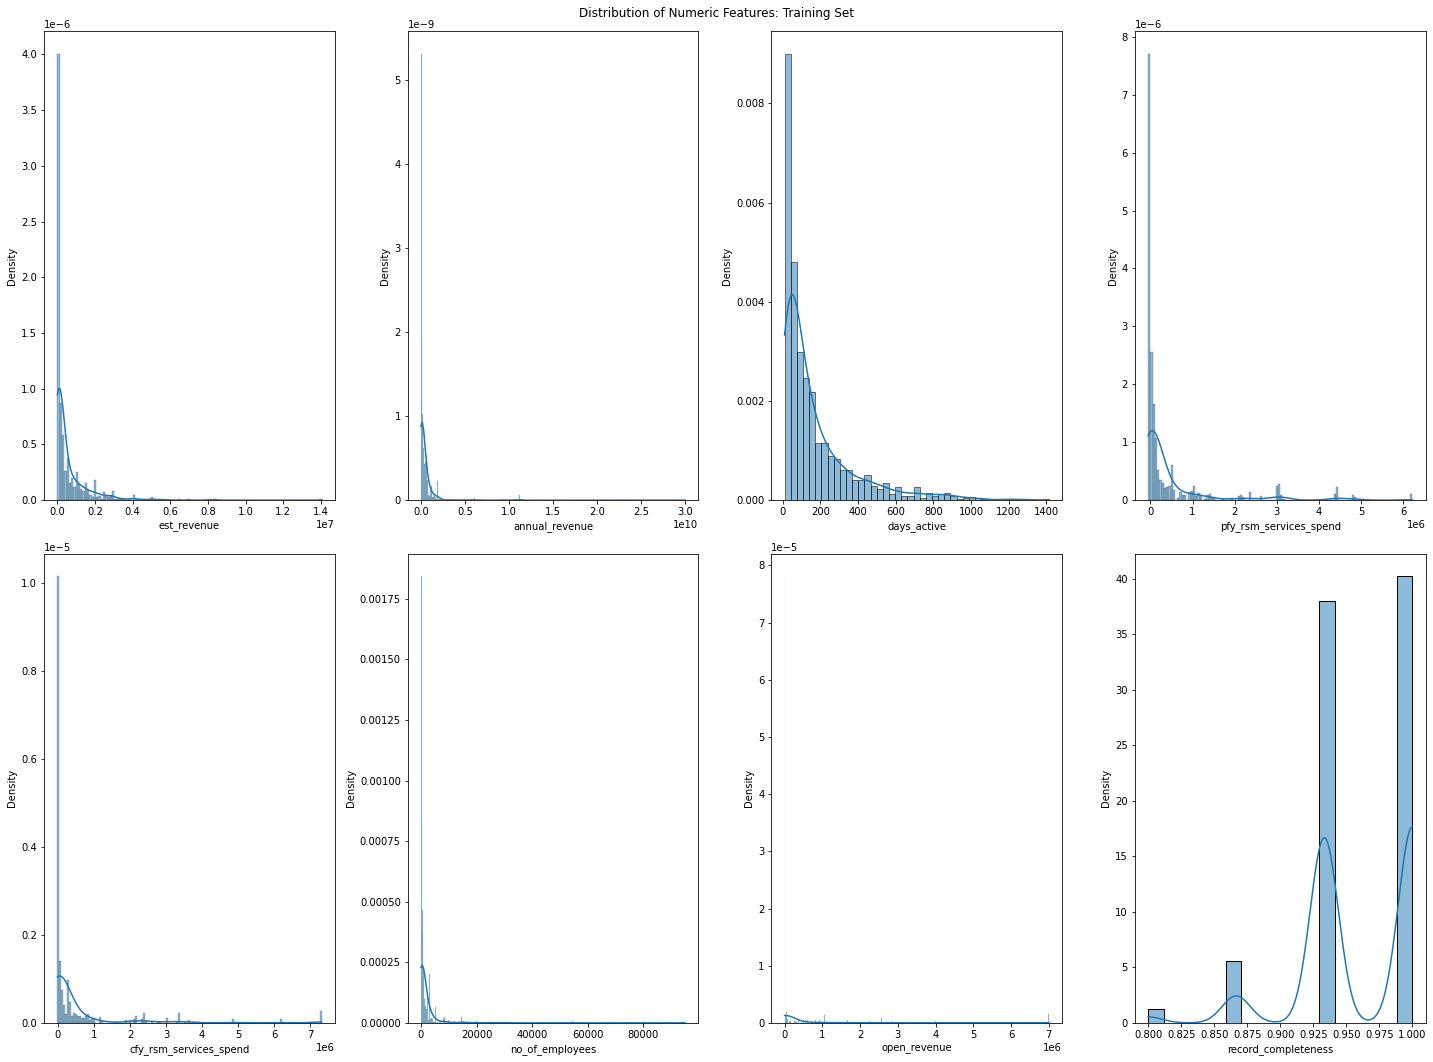

In [24]:
"""plot the distribution numeric features in the training set"""

fig, ax = plt.subplots(2, 4, figsize=(20, 15))
sns.histplot(data=X_train, x='est_revenue', stat='density', kde=True, ax=ax[0, 0])
sns.histplot(data=X_train, x='annual_revenue', stat='density', kde=True, ax=ax[0, 1])
sns.histplot(data=X_train, x='days_active', stat='density', kde=True, ax=ax[0, 2])
sns.histplot(data=X_train, x='pfy_rsm_services_spend', stat='density', kde=True, ax=ax[0,3])
sns.histplot(data=X_train, x='cfy_rsm_services_spend', stat='density', kde=True, ax=ax[1, 0])
sns.histplot(data=X_train, x='no_of_employees', stat='density', kde=True, ax=ax[1, 1])
sns.histplot(data=X_train, x='open_revenue', stat='density', kde=True, ax=ax[1, 2])
sns.histplot(data=X_train, x='record_completeness', stat='density', kde=True, ax=ax[1,3])
fig.suptitle('Distribution of Numeric Features: Training Set')
plt.tight_layout()

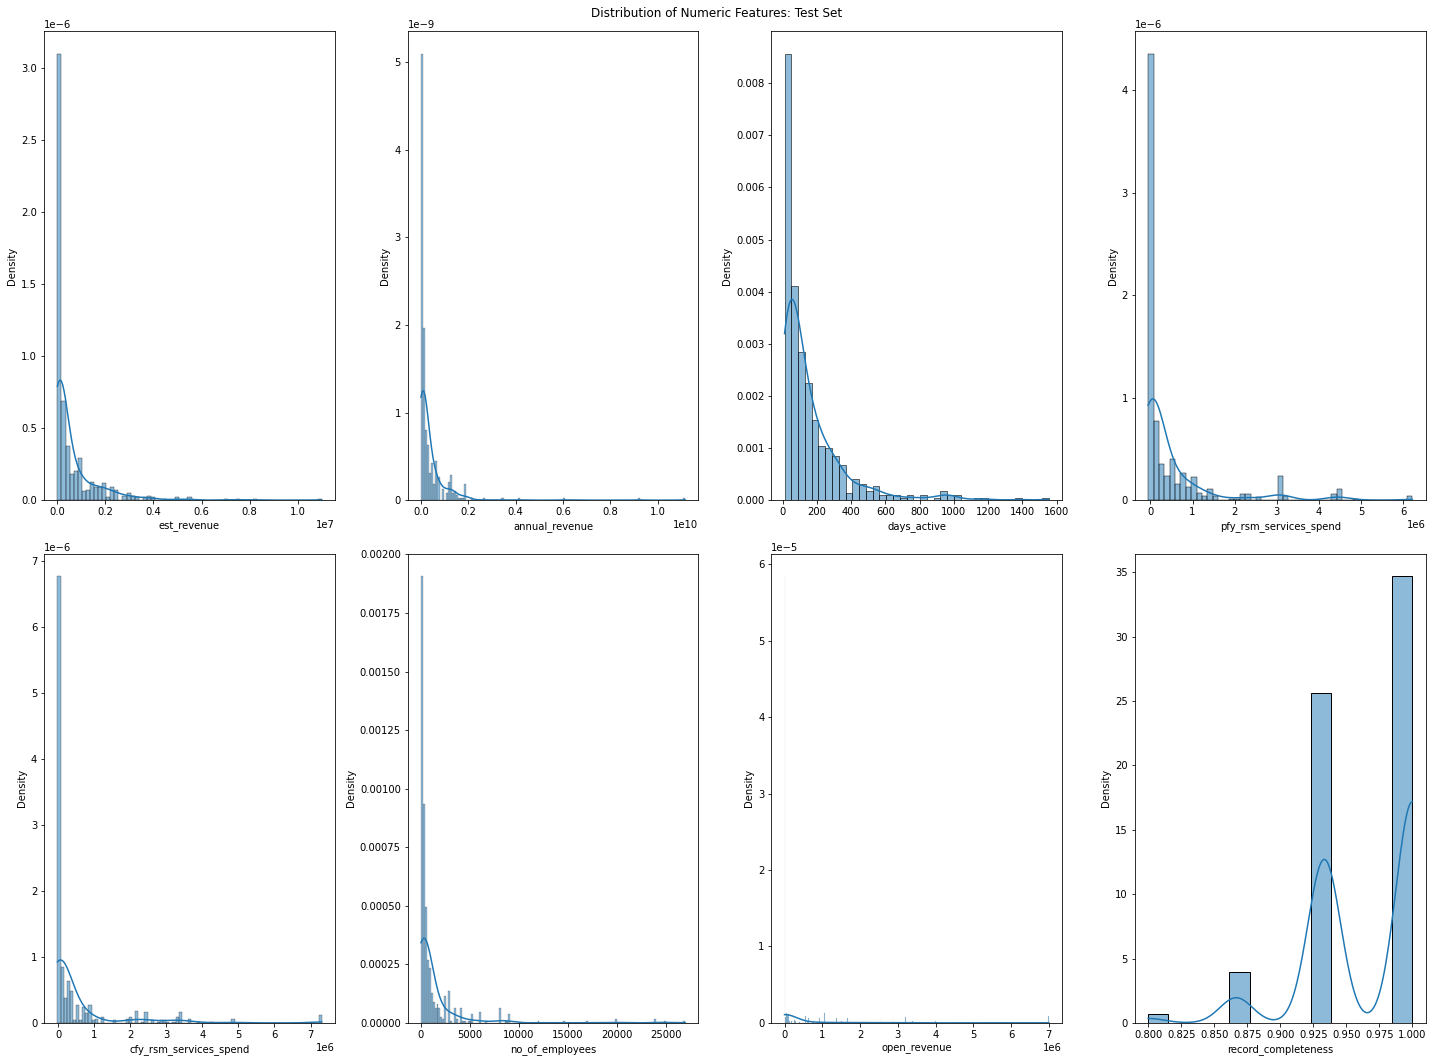

In [25]:
"""plot the distribution numeric features in the test set"""


fig, ax = plt.subplots(2, 4, figsize=(20, 15))
sns.histplot(data=X_test, x='est_revenue', stat='density', kde=True, ax=ax[0, 0])
plt.ticklabel_format(style='plain')
sns.histplot(data=X_test, x='annual_revenue', stat='density', kde=True, ax=ax[0, 1])
sns.histplot(data=X_test, x='days_active', stat='density', kde=True, ax=ax[0, 2])
sns.histplot(data=X_test, x='pfy_rsm_services_spend', stat='density', kde=True, ax=ax[0,3])
sns.histplot(data=X_test, x='cfy_rsm_services_spend', stat='density', kde=True, ax=ax[1, 0])
sns.histplot(data=X_test, x='no_of_employees', stat='density', kde=True, ax=ax[1, 1])
sns.histplot(data=X_test, x='open_revenue', stat='density', kde=True, ax=ax[1, 2])
sns.histplot(data=X_test, x='record_completeness', stat='density', kde=True, ax=ax[1,3])
fig.suptitle('Distribution of Numeric Features: Test Set')
plt.tight_layout()

Plot correlation heatmap of numeric features

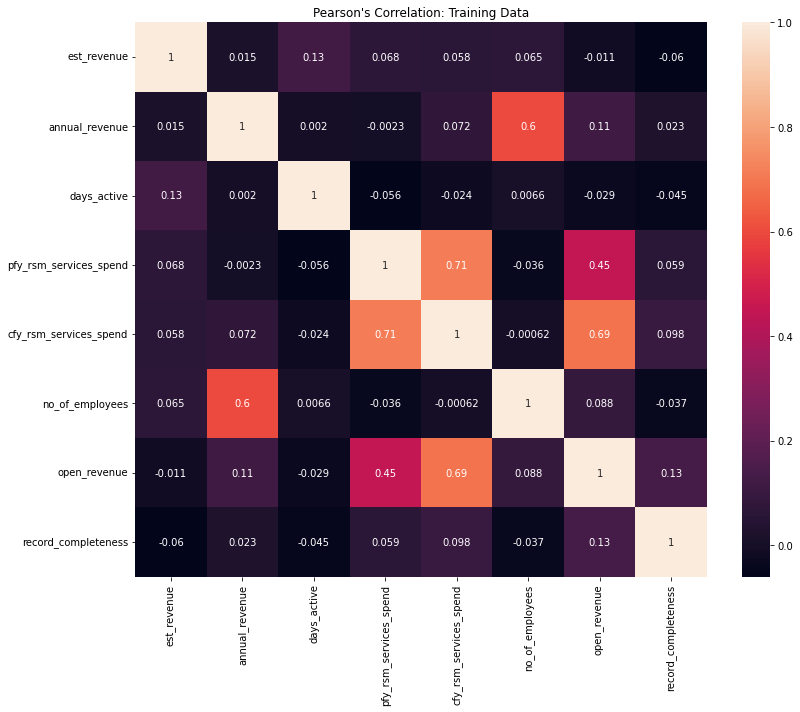

In [27]:
"""plot correlation, training set"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(X_train[numeric_features].corr(), annot=True)
plt.title('Pearson\'s Correlation: Training Data')
plt.tight_layout()
plt.show()

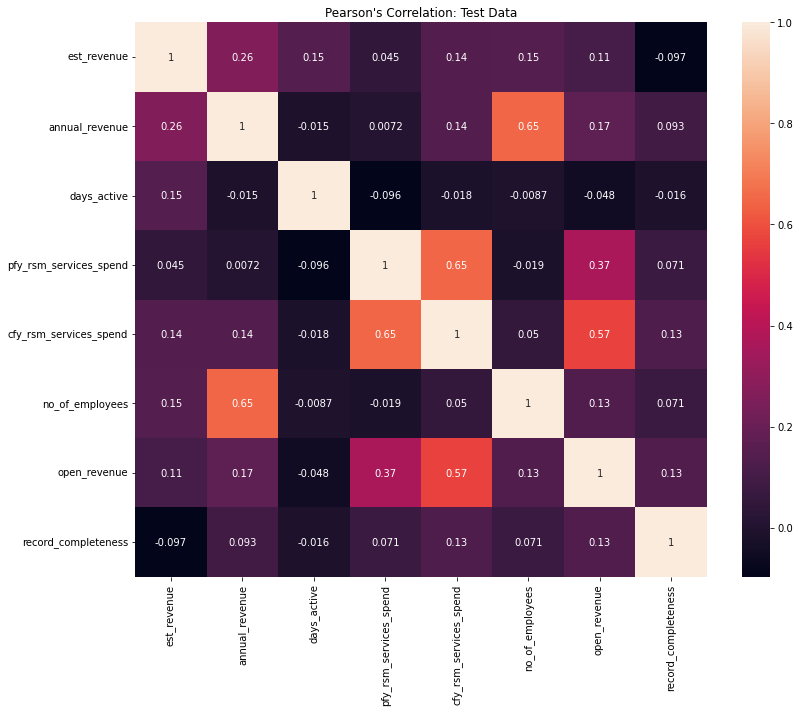

In [28]:
"""plot correlation, test set"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(X_test[numeric_features].corr(), annot=True)
plt.title('Pearson\'s Correlation: Test Data')
plt.tight_layout()
plt.show()

Create a bar plot of wins vs losses for opportunity records

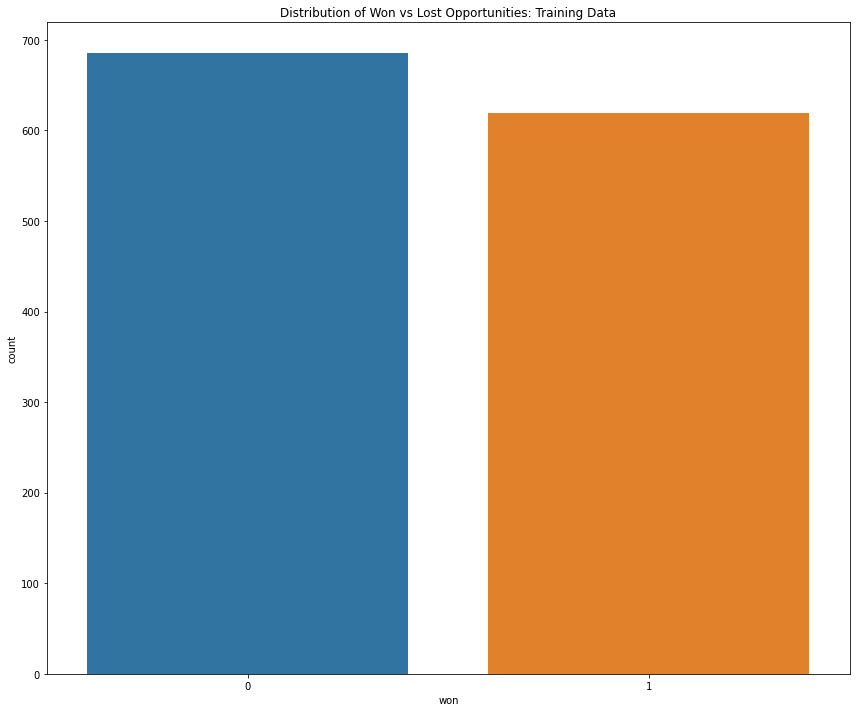

In [29]:
"""bar plot of wins vs losses in the training data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=y_train, x='won')
plt.title('Distribution of Won vs Lost Opportunities: Training Data')
plt.tight_layout()
plt.show()

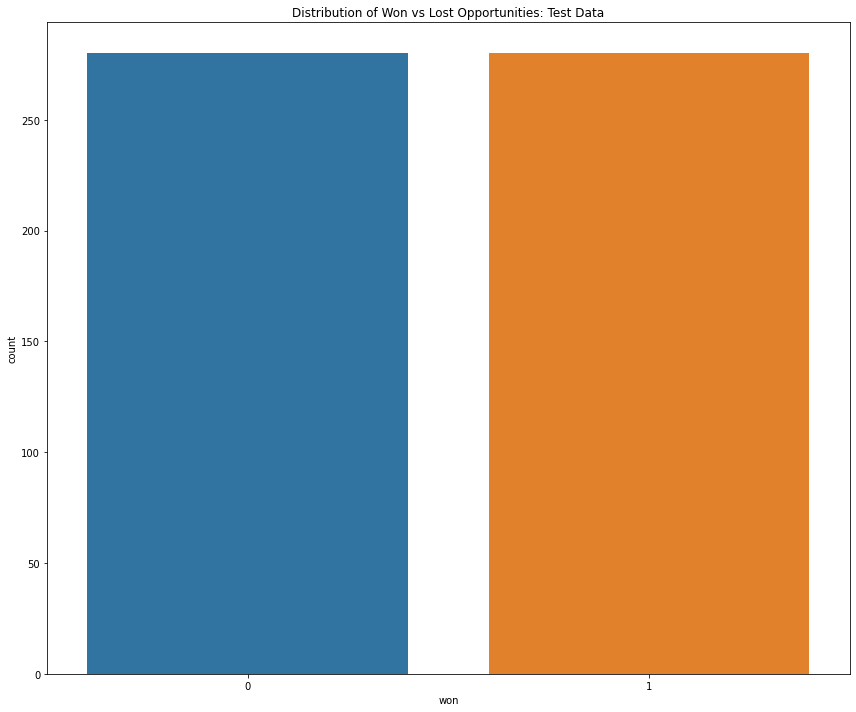

In [30]:
"""bar plot of wins vs losses in the test data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=y_test, x='won')
plt.title('Distribution of Won vs Lost Opportunities: Test Data')
plt.tight_layout()
plt.show()

Create a bar plot of wins vs losses for opportunity records binned by market segment

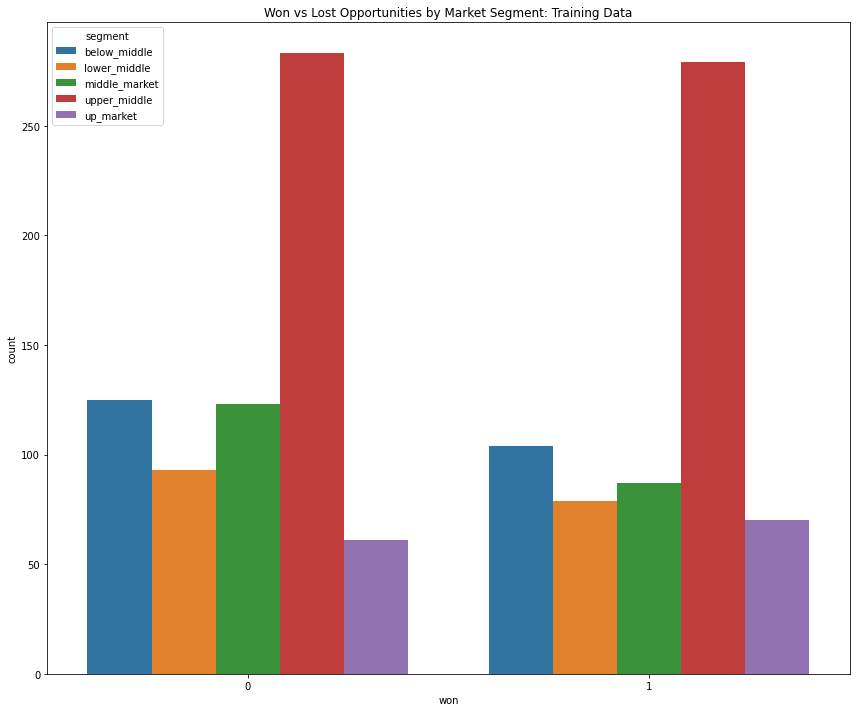

In [31]:
"""distribution of wins vs losses binned by segment, training data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=pd.merge(X_train, y_train, left_index=True, right_index=True, how='inner')[['segment', 'won']],
              x='won', hue='segment')
plt.title('Won vs Lost Opportunities by Market Segment: Training Data')
plt.tight_layout()
plt.show()

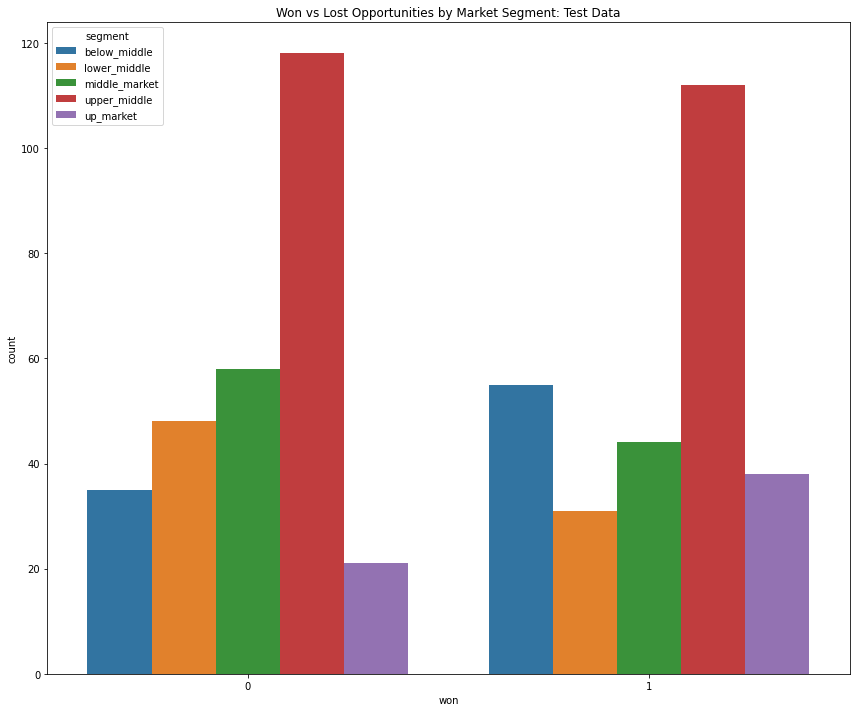

In [32]:
"""distribution of wins vs losses binned by segment, test data"""

fig, ax = plt.subplots(figsize=(12, 10))
sns.countplot(data=pd.merge(X_test, y_test, left_index=True, right_index=True, how='inner')[['segment', 'won']],
              x='won', hue='segment')
plt.title('Won vs Lost Opportunities by Market Segment: Test Data')
plt.tight_layout()
plt.show()

Create a scatter plot of days_active vs estimated_revenue with hue to signify if data points were won or lost opportunities

Text(0.5, 0.98, 'Scatter of Days Active vs Estimated Revenue: Training Data')

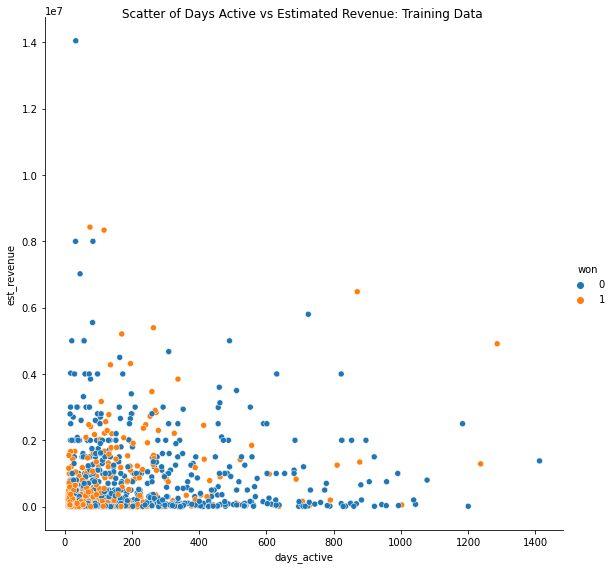

In [33]:
"""scatter of days_active vs est_revenue colored by win or loss, training data"""

plot = sns.relplot(data=pd.merge(X_train, y_train, left_index=True, right_index=True, how='inner')[['days_active', 'est_revenue', 'won']],
             x='days_active', y='est_revenue', hue='won', height=8, aspect=1.0)
plot.fig.suptitle('Scatter of Days Active vs Estimated Revenue: Training Data')

Text(0.5, 0.98, 'Scatter of Days Active vs Estimated Revenue: Test Data')

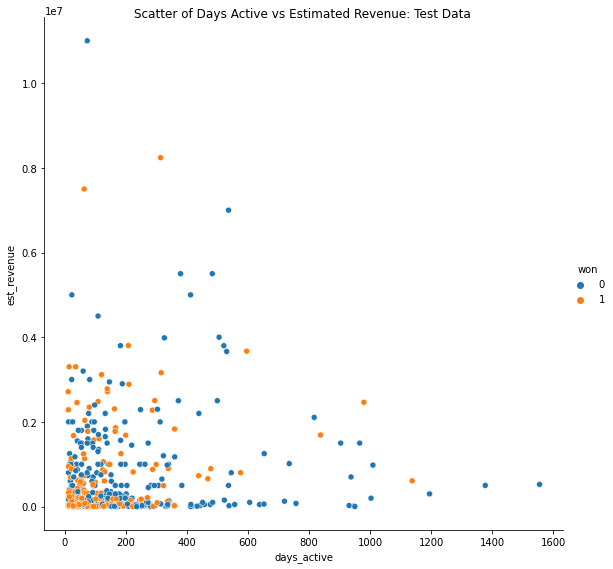

In [34]:
"""scatter of days_active vs est_revenue colored by win or loss, test data"""

plot = sns.relplot(data=pd.merge(X_test, y_test, left_index=True, right_index=True, how='inner')[['days_active', 'est_revenue', 'won']],
             x='days_active', y='est_revenue', hue='won', height=8, aspect=1.0)
plot.fig.suptitle('Scatter of Days Active vs Estimated Revenue: Test Data')

## *Model Construction and Evaluation*

*Objectives*

- Create a helper function to get the index of categorical and numeric features in the data.
- Apply model specific preprocessing to the data.
- Construct models, tune select hyperparameters, and perform cross-validation on the training set. The following classification algorithms will be tested:
    - Support Vector Classification
    - Decision Tree Classification
    - Random Forest Classification
    - Logistic Regression 
- Apply further hyperparameter tuning to the best performing algorithm.
- Assess performance of the tuned model when applied to the test set.


### Apply model-specific preprocessing to the data.

In [36]:
"""helper function to return indeces of different datatypes in the feature set"""

def get_dtype_idx(data):

    # get numeric features index as list
    numeric_idx = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # get categroical features index as list
    categorical_idx = X_train.select_dtypes(include=['bool', 'object', 'category']).columns.tolist()

    # return indices
    return numeric_idx, categorical_idx

In [37]:
"""apply model specific preprocessing to the data"""

# get index of categorical and numeric features in the data
numeric_idx, categorical_idx = get_dtype_idx(X_train)
# define a column transformer to prepare data for support vector classification
column_transformer = make_column_transformer((OneHotEncoder(sparse=False), categorical_idx),
                                             (StandardScaler(), numeric_idx),
                                             remainder='passthrough')
# apply colmun transformer to training data
X_train_transformed = column_transformer.fit_transform(X_train)
X_train_transformed = pd.DataFrame(data=X_train_transformed, columns=column_transformer.get_feature_names_out())
# apply column transformer to test data
X_test_transformed = column_transformer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(data=X_test_transformed, columns=column_transformer.get_feature_names_out())

### Construct models, select best features, and perform cross-validation on the training set

#### Support Vector Classification

In [38]:
"""perform initial hyperparameter tuning for support vector classifier"""

params = {'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}
svc_grid_search = GridSearchCV(SVC(random_state=42), params, cv=3)
svc_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
print("The optimal hyperparameters for the support vector classifier are:", svc_grid_search.best_params_)

The optimal hyperparameters for the support vector classifier are: {'gamma': 0.1, 'kernel': 'rbf'}


In [39]:
"""print the accuracy of the model applied to the training set"""

svc_grid_search.score(X_train_transformed, y_train)

0.8266871165644172

In [40]:
"""print accuracy score of the best estimator applied to the test set"""

# get the best estimator from grid search
svc = svc_grid_search.best_estimator_
# apply the estimator to the test set and print results
svc.score(X_test_transformed, y_test.to_numpy().flatten())

0.7839285714285714

#### Decision Tree Classification

In [41]:
"""perform initial hyperparameter tuning for decision tree classifier"""

params = {'max_depth': range(1, 51), 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1.0]}
dtc_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=3)
dtc_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
print("The optimal hyperparameters for the decision tree classifier are:", dtc_grid_search.best_params_)

The optimal hyperparameters for the decision tree classifier are: {'max_depth': 8, 'max_features': 0.5}


In [42]:
"""print the accuracy of the model applied to the training set"""

dtc_grid_search.score(X_train_transformed, y_train)

0.9141104294478528

In [43]:
"""print accuracy sore of the best estimator applied to the test set"""

# apply colmun transformer to test data and
X_test_transformed = column_transformer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(data=X_test_transformed, columns=column_transformer.get_feature_names_out())
# get the best estimator from grid search
dtc = dtc_grid_search.best_estimator_
# apply the estimator to the test set and print results
dtc.score(X_test_transformed, y_test.to_numpy().flatten())

0.7107142857142857

### Random Forest Classification

In [44]:
"""perform initial hyperparameter tuning for random forest classifier"""

params = {'max_depth': range(1, 31), 'max_features': [0.2, 0.4, 0.6, 0.8, 1.0]}
rfc_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params,
                               scoring='accuracy', cv=3)
rfc_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
best_params = rfc_grid_search.best_params_
print("The optimal hyperparameters for the random forest classifier are:", best_params)

The optimal hyperparameters for the random forest classifier are: {'max_depth': 12, 'max_features': 0.4}


In [45]:
"""print the accuracy of the model applied to the training set"""

rfc_grid_search.score(X_train_transformed, y_train)

0.9892638036809815

In [46]:
"""print accuracy score of the best estimator applied to the test set"""

# apply colmun transformer to test data and
X_test_transformed = column_transformer.fit_transform(X_test)
X_test_transformed = pd.DataFrame(data=X_test_transformed, columns=column_transformer.get_feature_names_out())
# get the best estimator from grid search
rfc = rfc_grid_search.best_estimator_
# apply the estimator to the test set and print results
rfc.score(X_test_transformed, y_test.to_numpy().flatten())

0.7857142857142857

#### Logistic Regression

In [47]:
"""perform initial hyperparameter tuning for logistic regression"""

params = {'C': [0.5, 1.0, 2.0, 5.0, 10.0]}
lr_grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=params, cv=3)
lr_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
print("The optimal hyperparameters for the logistic regression model are:", lr_grid_search.best_params_)

The optimal hyperparameters for the logistic regression model are: {'C': 5.0}


In [48]:
"""print the accuracy of the model applied to the training set"""

lr_grid_search.score(X_train_transformed, y_train)

0.7967791411042945

In [49]:
"""print accuracy score  of the best estimator applied to the test set"""

# get the best estimator from grid search
lr = lr_grid_search.best_estimator_
# apply the estimator to the test set and print results
lr.score(X_test_transformed, y_test.to_numpy().flatten())

0.7732142857142857

### Apply further hyperparameter tuning to the best performing algorithm.

#### Random Forest Classifier Hyperparameter Tuning

In [51]:
"""apply further hyperparamter tuning to random forest classifier"""

# 
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
# define grid search to tune the model                                            
params = {'max_depth': [12], 'max_features': [0.4], 'n_estimators': [100, 200, 250],
          'min_samples_leaf': [1, 2, 4], 'min_samples_split': [2, 4, 6, 8]}
rfc_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=params, cv=cv, scoring='accuracy')
# fit the grid
rfc_grid_search.fit(X_train_transformed, y_train.to_numpy().flatten())
# print the best params
print("The optimal hyperparameters for the random forest classifier are:", rfc_grid_search.best_params_)

The optimal hyperparameters for the random forest classifier are: {'max_depth': 12, 'max_features': 0.4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [52]:
"""print classification report of the best estimator applied to the training set"""

# get the best estimator from grid search
rfc = rfc_grid_search.best_estimator_
# apply the estimator to the test set and print classification report
y_train_pred = rfc.predict(X_train_transformed)
print(classification_report(y_train.to_numpy().flatten(), y_train_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       685
           1       0.97      0.96      0.97       619

    accuracy                           0.97      1304
   macro avg       0.97      0.97      0.97      1304
weighted avg       0.97      0.97      0.97      1304



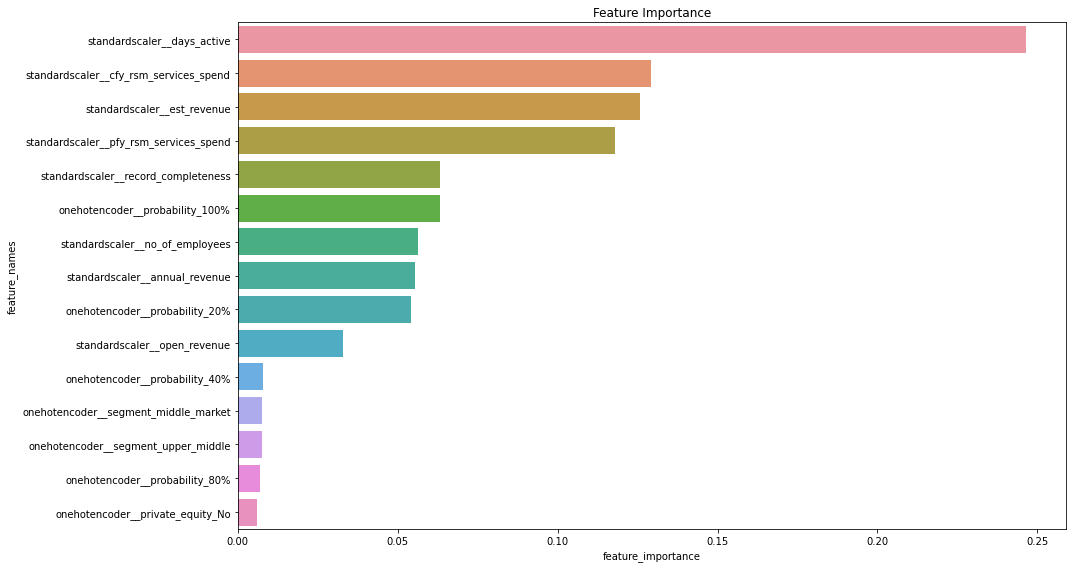

In [53]:
"""plot the featue importance of the random forest model"""

feature_importances = rfc_grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, X_train_transformed.columns))
#Create a DataFrame of results
model_results = {'feature_names':X_train_transformed.columns,'feature_importance':feature_importances}
model_results = pd.DataFrame(model_results)
# sort results by decreasing feature importance
model_results.sort_values(by=['feature_importance'], ascending=False,inplace=True)
# specify plot size
plt.figure(figsize=(15,8))
# create the plot using top 20% best features by importance
sns.barplot(x=model_results['feature_importance'][0:15], y=model_results['feature_names'][0:15])
# add labels
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [54]:
"""print classification report of the best estimator applied to the test set"""

# get the best estimator from grid search
rfc = rfc_grid_search.best_estimator_
# apply the estimator to the test set and print classification report
y_test_pred = rfc.predict(X_test_transformed)
print(classification_report(y_test.to_numpy().flatten(), y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80       280
           1       0.81      0.76      0.78       280

    accuracy                           0.79       560
   macro avg       0.79      0.79      0.79       560
weighted avg       0.79      0.79      0.79       560

